<a href="https://colab.research.google.com/github/shivam110601/loan-approval-prediction/blob/main/loan_approval_prediction_using_catboost_best_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## *1. Import Modules and Libraries*


In [1]:
!pip install --upgrade patsy statsmodels seaborn

In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostClassifier

In [4]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## *2. Read Dataset*

In [5]:
test_file = "/content/test.csv"
train_file = "/content/train.csv"
og_file = "/content/credit_risk_dataset.csv"

In [28]:
train_df = pd.read_csv(train_file, index_col='id')
test_df = pd.read_csv(test_file, index_col='id')
og_df = pd.read_csv(og_file)

In [8]:
print("Shape of Training file:", train_df.shape)
print("Shape of Testing file:", test_df.shape)
print("Shape of Original file:", og_df.shape)

Shape of Training file: (58645, 12)
Shape of Testing file: (39098, 11)
Shape of Original file: (32581, 12)


## *3. Analyze Dataset*

In [10]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [13]:
from IPython.display import display

In [15]:
display(train_df.head())
display(test_df.head())
display(og_df.head())

person_age  person_income person_home_ownership  person_emp_length  \
id                                                                       
0           37          35000                  RENT                0.0   
1           22          56000                   OWN                6.0   
2           29          28800                   OWN                8.0   
3           30          70000                  RENT               14.0   
4           22          60000                  RENT                2.0   

   loan_intent loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
id                                                                         
0    EDUCATION          B       6000          11.49                 0.17   
1      MEDICAL          C       4000          13.35                 0.07   
2     PERSONAL          A       6000           8.90                 0.21   
3      VENTURE          B      12000          11.11                 0.17   
4      MEDICAL          A       6000           6.92                 0.10   

   cb_person_default_on_file  cb_person_cred_hist_length  loan_status  
id                                                                     
0                          N                          14            0  
1                          N                           2            0  
2                          N                          10            0  
3                          N                           5            0  
4                          N                           3            0

person_age  person_income person_home_ownership  person_emp_length  \
id                                                                          
58645          23          69000                  RENT                3.0   
58646          26          96000              MORTGAGE                6.0   
58647          26          30000                  RENT                5.0   
58648          33          50000                  RENT                4.0   
58649          26         102000              MORTGAGE                8.0   

             loan_intent loan_grade  loan_amnt  loan_int_rate  \
id                                                              
58645    HOMEIMPROVEMENT          F      25000          15.76   
58646           PERSONAL          C      10000          12.68   
58647            VENTURE          E       4000          17.19   
58648  DEBTCONSOLIDATION          A       7000           8.90   
58649    HOMEIMPROVEMENT          D      15000          16.32   

       loan_percent_income cb_person_default_on_file  \
id                                                     
58645                 0.36                         N   
58646                 0.10                         Y   
58647                 0.13                         Y   
58648                 0.14                         N   
58649                 0.15                         Y   

       cb_person_cred_hist_length  
id                                 
58645                           2  
58646                           4  
58647                           2  
58648                           7  
58649                           4

person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  
1                 0.10                         N                           2  
2                 0.57                         N                           3  
3                 0.53                         N                           2  
4                 0.55                         Y                           4

In [18]:
display(train_df.info())
display(test_df.info())
display(og_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
Index: 39098 entries, 58645 to 97742
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  39098 non-null  int64  
 1   person_income               39098 non-null  int64  
 2   person_home_ownership       39098 non-null  object 
 3   person_emp_length           39098 non-null  float64
 4   loan_intent                 39098 non-null  object 
 5   loan_grade                  39098 non-null  object 
 6   loan_amnt                   39098 non-null  int64  
 7   loan_int_rate               39098 non-null  float64
 8   loan_percent_income         39098 non-null  float64
 9   cb_person_default_on_file   39098 non-null  object 
 10  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 3.6+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


None

In [19]:
num_cols = train_df.select_dtypes(include=['number']).columns
num_cols

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'loan_status'],
      dtype='object')

In [20]:
obj_cols = train_df.select_dtypes(include=['object']).columns.to_list()
obj_cols

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file']

In [21]:
print("Numerical Column description")
for col in num_cols:
  print(f"\n{col}:\n", og_df[col].describe())

Numerical Column description

person_age:
 count    32581.000000
mean        27.734600
std          6.348078
min         20.000000
25%         23.000000
50%         26.000000
75%         30.000000
max        144.000000
Name: person_age, dtype: float64

person_income:
 count    3.258100e+04
mean     6.607485e+04
std      6.198312e+04
min      4.000000e+03
25%      3.850000e+04
50%      5.500000e+04
75%      7.920000e+04
max      6.000000e+06
Name: person_income, dtype: float64

person_emp_length:
 count    31686.000000
mean         4.789686
std          4.142630
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        123.000000
Name: person_emp_length, dtype: float64

loan_amnt:
 count    32581.000000
mean      9589.371106
std       6322.086646
min        500.000000
25%       5000.000000
50%       8000.000000
75%      12200.000000
max      35000.000000
Name: loan_amnt, dtype: float64

loan_int_rate:
 count    29465.000000
mean        11.011695


In [22]:
print("Unique values in Object type columns")
for col in obj_cols:
    print(f"\n\n{col}: ", train_df[col].unique().shape[0], "\nUnique values: ", train_df[col].unique())
    print(f"\n{col}: ", test_df[col].unique().shape[0], "\nUnique values: ", test_df[col].unique())
    print(f"\n{col}: ", og_df[col].unique().shape[0], "\nUnique values: ", og_df[col].unique())

Unique values in Object type columns


person_home_ownership:  4 
Unique values:  ['RENT' 'OWN' 'MORTGAGE' 'OTHER']

person_home_ownership:  4 
Unique values:  ['RENT' 'MORTGAGE' 'OWN' 'OTHER']

person_home_ownership:  4 
Unique values:  ['RENT' 'OWN' 'MORTGAGE' 'OTHER']


loan_intent:  6 
Unique values:  ['EDUCATION' 'MEDICAL' 'PERSONAL' 'VENTURE' 'DEBTCONSOLIDATION'
 'HOMEIMPROVEMENT']

loan_intent:  6 
Unique values:  ['HOMEIMPROVEMENT' 'PERSONAL' 'VENTURE' 'DEBTCONSOLIDATION' 'EDUCATION'
 'MEDICAL']

loan_intent:  6 
Unique values:  ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']


loan_grade:  7 
Unique values:  ['B' 'C' 'A' 'D' 'E' 'F' 'G']

loan_grade:  7 
Unique values:  ['F' 'C' 'E' 'A' 'D' 'B' 'G']

loan_grade:  7 
Unique values:  ['D' 'B' 'C' 'A' 'E' 'F' 'G']


cb_person_default_on_file:  2 
Unique values:  ['N' 'Y']

cb_person_default_on_file:  2 
Unique values:  ['N' 'Y']

cb_person_default_on_file:  2 
Unique values:  ['Y' 'N']


In [29]:
print(train_df.duplicated().sum())
print(test_df.duplicated().sum())
print(og_df.duplicated().sum())

0
0
165


In [30]:
duplicated_rows = og_df[og_df.duplicated(keep=False)]
display(duplicated_rows)

person_age  person_income person_home_ownership  person_emp_length  \
14             23         115000                  RENT                2.0   
238            22         183000              MORTGAGE                3.0   
252            24          85000                  RENT                5.0   
591            26          20000              MORTGAGE                5.0   
740            21          21600                   OWN                NaN   
...           ...            ...                   ...                ...   
32010          42          39996              MORTGAGE                2.0   
32047          36         250000                  RENT                2.0   
32172          49         120000              MORTGAGE               12.0   
32259          39          40000                   OWN                4.0   
32279          43          11340                  RENT                4.0   

             loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
14             EDUCATION          A      35000           7.90            0   
238            EDUCATION          A       1000            NaN            0   
252              MEDICAL          B      25000          10.62            0   
591              MEDICAL          A       4800           5.99            0   
740              VENTURE          A       7125           6.99            0   
...                  ...        ...        ...            ...          ...   
32010    HOMEIMPROVEMENT          A       2500           5.42            0   
32047  DEBTCONSOLIDATION          A      20000           7.88            0   
32172            MEDICAL          B      12000          10.99            0   
32259            VENTURE          B       1000          10.37            0   
32279          EDUCATION          C       1950            NaN            1   

       loan_percent_income cb_person_default_on_file  \
14                    0.30                         N   
238                   0.01                         N   
252                   0.29                         N   
591                   0.24                         N   
740                   0.33                         N   
...                    ...                       ...   
32010                 0.06                         N   
32047                 0.08                         N   
32172                 0.10                         N   
32259                 0.03                         N   
32279                 0.17                         N   

       cb_person_cred_hist_length  
14                              4  
238                             2  
252                             4  
591                             3  
740                             3  
...                           ...  
32010                          12  
32047                          17  
32172                          12  
32259                          16  
32279                          11  

[330 rows x 12 columns]

In [70]:
og_nd_df = og_df.drop_duplicates(keep='first').copy()
print(og_df.shape, og_nd_df.shape)

(32581, 12) (32416, 12)


In [71]:
og_nd_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32416 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32416 non-null  int64  
 1   person_income               32416 non-null  int64  
 2   person_home_ownership       32416 non-null  object 
 3   person_emp_length           31529 non-null  float64
 4   loan_intent                 32416 non-null  object 
 5   loan_grade                  32416 non-null  object 
 6   loan_amnt                   32416 non-null  int64  
 7   loan_int_rate               29321 non-null  float64
 8   loan_status                 32416 non-null  int64  
 9   loan_percent_income         32416 non-null  float64
 10  cb_person_default_on_file   32416 non-null  object 
 11  cb_person_cred_hist_length  32416 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.2+ MB


In [73]:
empty_rows_count = og_nd_df.isnull().any(axis=1).sum()
print("Number of rows with any empty columns:", empty_rows_count)


Number of rows with any empty columns: 3915


In [74]:
for col in ['loan_int_rate', 'person_emp_length']:
  print(f"\nUnique values and counts for {col}:")
  print(og_nd_df[col].value_counts())
  print(f"\nNumber of empty entries for {col}: {og_nd_df[col].isnull().sum()}")



Unique values and counts for loan_int_rate:
loan_int_rate
7.51     754
10.99    745
7.49     638
7.88     636
5.42     588
        ... 
21.64      1
17.46      1
21.14      1
20.48      1
20.53      1
Name: count, Length: 348, dtype: int64

Number of empty entries for loan_int_rate: 3095

Unique values and counts for person_emp_length:
person_emp_length
0.0      4086
2.0      3832
3.0      3442
5.0      2926
1.0      2897
4.0      2863
6.0      2652
7.0      2186
8.0      1676
9.0      1359
11.0      735
10.0      692
12.0      571
13.0      426
14.0      334
15.0      238
16.0      165
17.0      128
18.0      104
19.0       64
20.0       42
21.0       38
22.0       19
24.0       10
23.0       10
25.0        8
26.0        6
27.0        5
31.0        4
28.0        3
123.0       2
30.0        2
41.0        1
34.0        1
29.0        1
38.0        1
Name: count, dtype: int64

Number of empty entries for person_emp_length: 887


In [75]:
#@title Fill missing values in numerical columns with the median
for col in og_nd_df.select_dtypes(include=['number']).columns:
  og_nd_df[col].fillna(og_nd_df[col].median(), inplace=True)



In [76]:
og_nd_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32416 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32416 non-null  int64  
 1   person_income               32416 non-null  int64  
 2   person_home_ownership       32416 non-null  object 
 3   person_emp_length           32416 non-null  float64
 4   loan_intent                 32416 non-null  object 
 5   loan_grade                  32416 non-null  object 
 6   loan_amnt                   32416 non-null  int64  
 7   loan_int_rate               32416 non-null  float64
 8   loan_status                 32416 non-null  int64  
 9   loan_percent_income         32416 non-null  float64
 10  cb_person_default_on_file   32416 non-null  object 
 11  cb_person_cred_hist_length  32416 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.2+ MB


In [85]:
merged_df = pd.concat([train_df, og_nd_df], axis=0)
merged_df = merged_df.drop_duplicates(keep='first')
display(merged_df)

person_age  person_income person_home_ownership  person_emp_length  \
0              37          35000                  RENT                0.0   
1              22          56000                   OWN                6.0   
2              29          28800                   OWN                8.0   
3              30          70000                  RENT               14.0   
4              22          60000                  RENT                2.0   
...           ...            ...                   ...                ...   
32576          57          53000              MORTGAGE                1.0   
32577          54         120000              MORTGAGE                4.0   
32578          65          76000                  RENT                3.0   
32579          56         150000              MORTGAGE                5.0   
32580          66          42000                  RENT                2.0   

           loan_intent loan_grade  loan_amnt  loan_int_rate  \
0            EDUCATION          B       6000          11.49   
1              MEDICAL          C       4000          13.35   
2             PERSONAL          A       6000           8.90   
3              VENTURE          B      12000          11.11   
4              MEDICAL          A       6000           6.92   
...                ...        ...        ...            ...   
32576         PERSONAL          C       5800          13.16   
32577         PERSONAL          A      17625           7.49   
32578  HOMEIMPROVEMENT          B      35000          10.99   
32579         PERSONAL          B      15000          11.48   
32580          MEDICAL          B       6475           9.99   

       loan_percent_income cb_person_default_on_file  \
0                     0.17                         N   
1                     0.07                         N   
2                     0.21                         N   
3                     0.17                         N   
4                     0.10                         N   
...                    ...                       ...   
32576                 0.11                         N   
32577                 0.15                         N   
32578                 0.46                         N   
32579                 0.10                         N   
32580                 0.15                         N   

       cb_person_cred_hist_length  loan_status  
0                              14            0  
1                               2            0  
2                              10            0  
3                               5            0  
4                               3            0  
...                           ...          ...  
32576                          30            0  
32577                          19            0  
32578                          28            1  
32579                          26            0  
32580                          30            0  

[91057 rows x 12 columns]

(91057, 12)

In [87]:
print("Unique values in Object type columns")
for col in obj_cols:
    print(f"\n\n{col}: ", merged_df[col].unique().shape[0], "\nUnique values: ", merged_df[col].unique())

Unique values in Object type columns


person_home_ownership:  4 
Unique values:  ['RENT' 'OWN' 'MORTGAGE' 'OTHER']


loan_intent:  6 
Unique values:  ['EDUCATION' 'MEDICAL' 'PERSONAL' 'VENTURE' 'DEBTCONSOLIDATION'
 'HOMEIMPROVEMENT']


loan_grade:  7 
Unique values:  ['B' 'C' 'A' 'D' 'E' 'F' 'G']


cb_person_default_on_file:  2 
Unique values:  ['N' 'Y']


In [88]:
print("Numerical Column description")
for col in num_cols:
  print(f"\n{col}:\n", merged_df[col].describe())

Numerical Column description

person_age:
 count    91057.000000
mean        27.619755
std          6.141995
min         20.000000
25%         23.000000
50%         26.000000
75%         30.000000
max        144.000000
Name: person_age, dtype: float64

person_income:
 count    9.105700e+04
mean     6.477301e+04
std      4.792188e+04
min      4.000000e+03
25%      4.000000e+04
50%      5.700000e+04
75%      7.800000e+04
max      6.000000e+06
Name: person_income, dtype: float64

person_emp_length:
 count    91057.000000
mean         4.722558
std          3.968436
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        123.000000
Name: person_emp_length, dtype: float64

loan_amnt:
 count    91057.000000
mean      9351.318427
std       5847.764684
min        500.000000
25%       5000.000000
50%       8000.000000
75%      12000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

loan_int_rate:
 count    91057.000000
mean        10.797753


## *4. Plots*

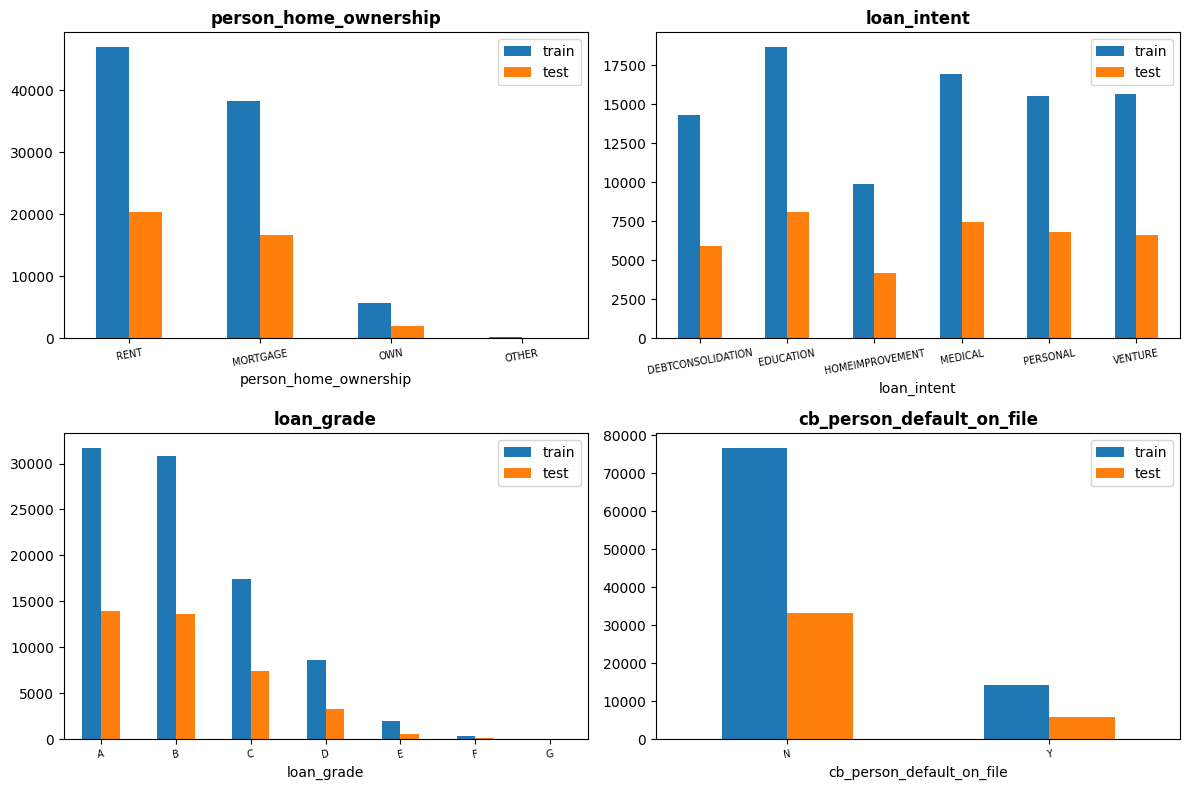

In [89]:
# @title 4.1 **Bar plot of Obj columns**

# Calculate the number of rows and columns for the grid
n_rows = 2
n_cols = 2

# Create the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))

# Iterate through the categorical columns and plot bar graphs
for i, col in enumerate(obj_cols):
    row = i // n_cols
    col_index = i % n_cols
    ax = axes[row, col_index]
    value_counts_train = merged_df[col].value_counts()
    value_counts_test = test_df[col].value_counts()

    # Combine value counts into a single DataFrame
    combined_counts = pd.DataFrame({'train': value_counts_train, 'test': value_counts_test, })

    # Plot the bar chart
    combined_counts.plot(kind='bar', ax=ax)
    ax.set_title(col, fontweight='bold')
    # ax.set_xlabel(col)
    # ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=10, labelsize=7)  # Rotate x-axis labels


plt.tight_layout()
plt.show()


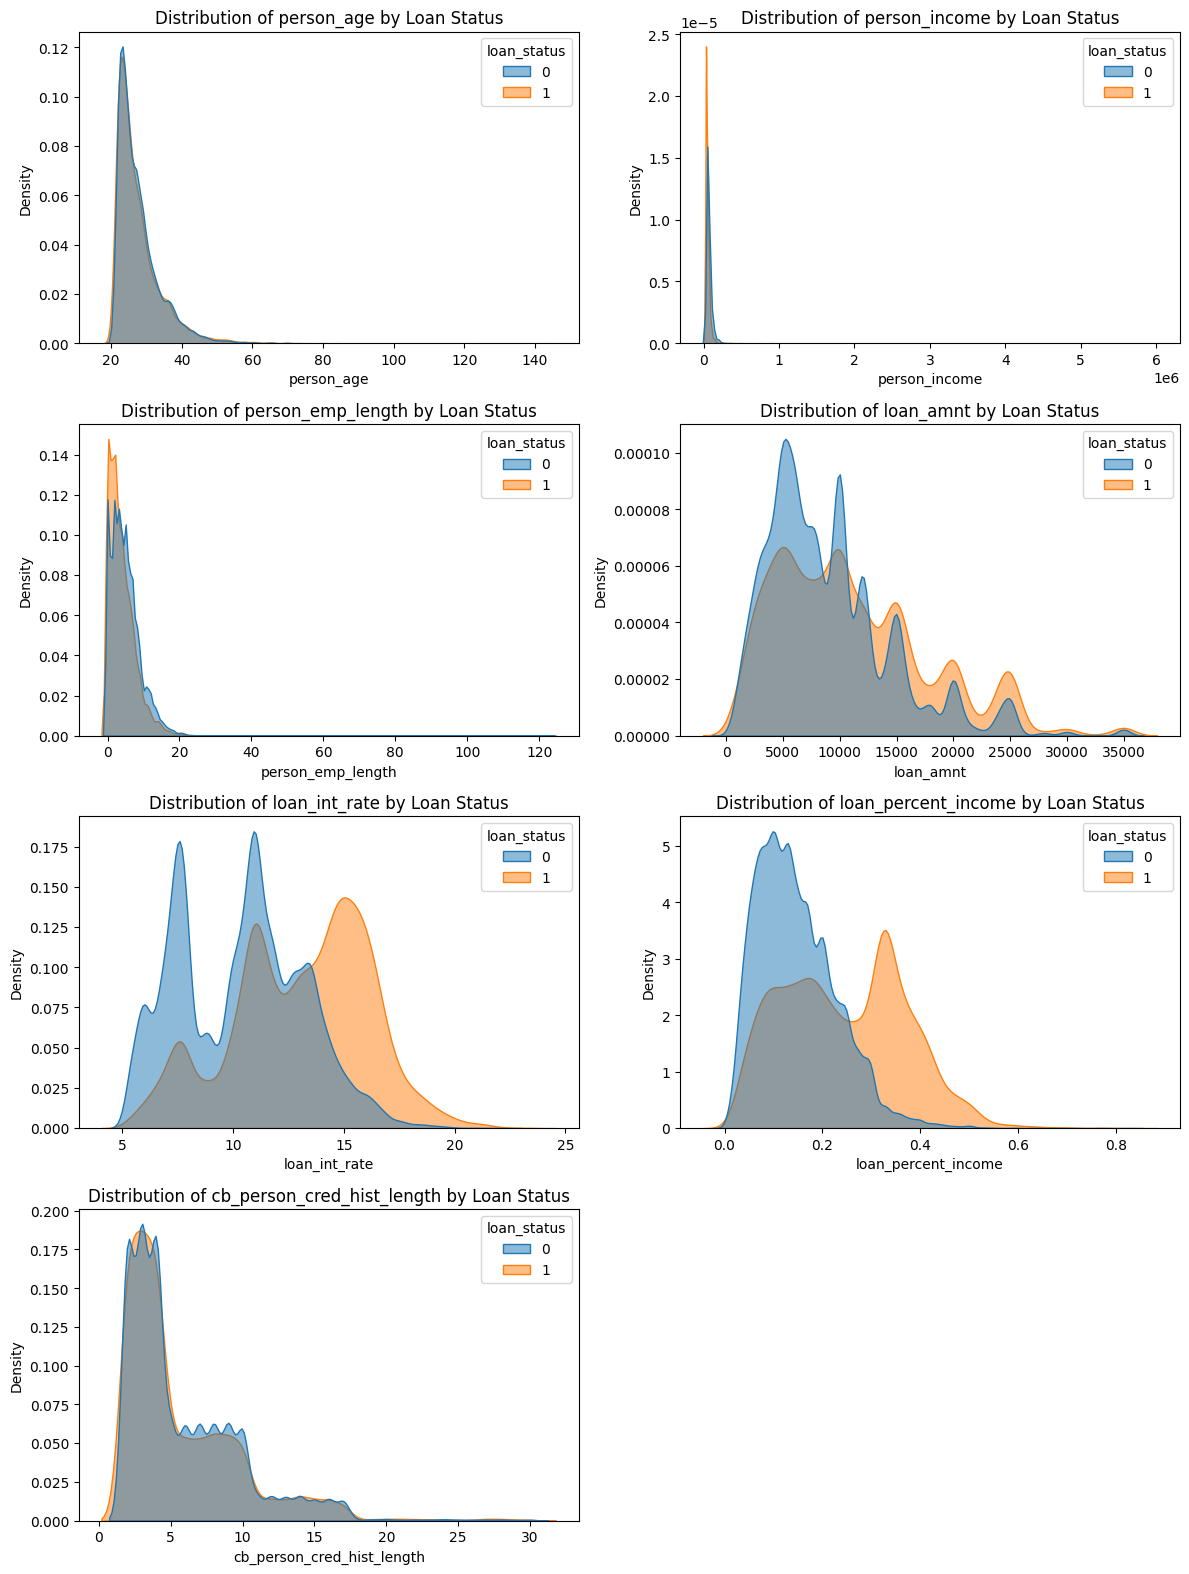

In [90]:
#@title 4.2 **Distribution of Numerical columns**

n_cols = 2
n_rows = (len(num_cols) + n_cols - 1) // n_cols


plt.figure(figsize=(12, 4 * n_rows))

for i, col in enumerate(num_cols, 1):
  if col != 'loan_status':
    plt.subplot(n_rows, n_cols, i)
    sns.kdeplot(data=merged_df, x=col, hue='loan_status', common_norm=False, fill=True, alpha=0.5)
    plt.title(f'Distribution of {col} by Loan Status')
    plt.xlabel(col)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()


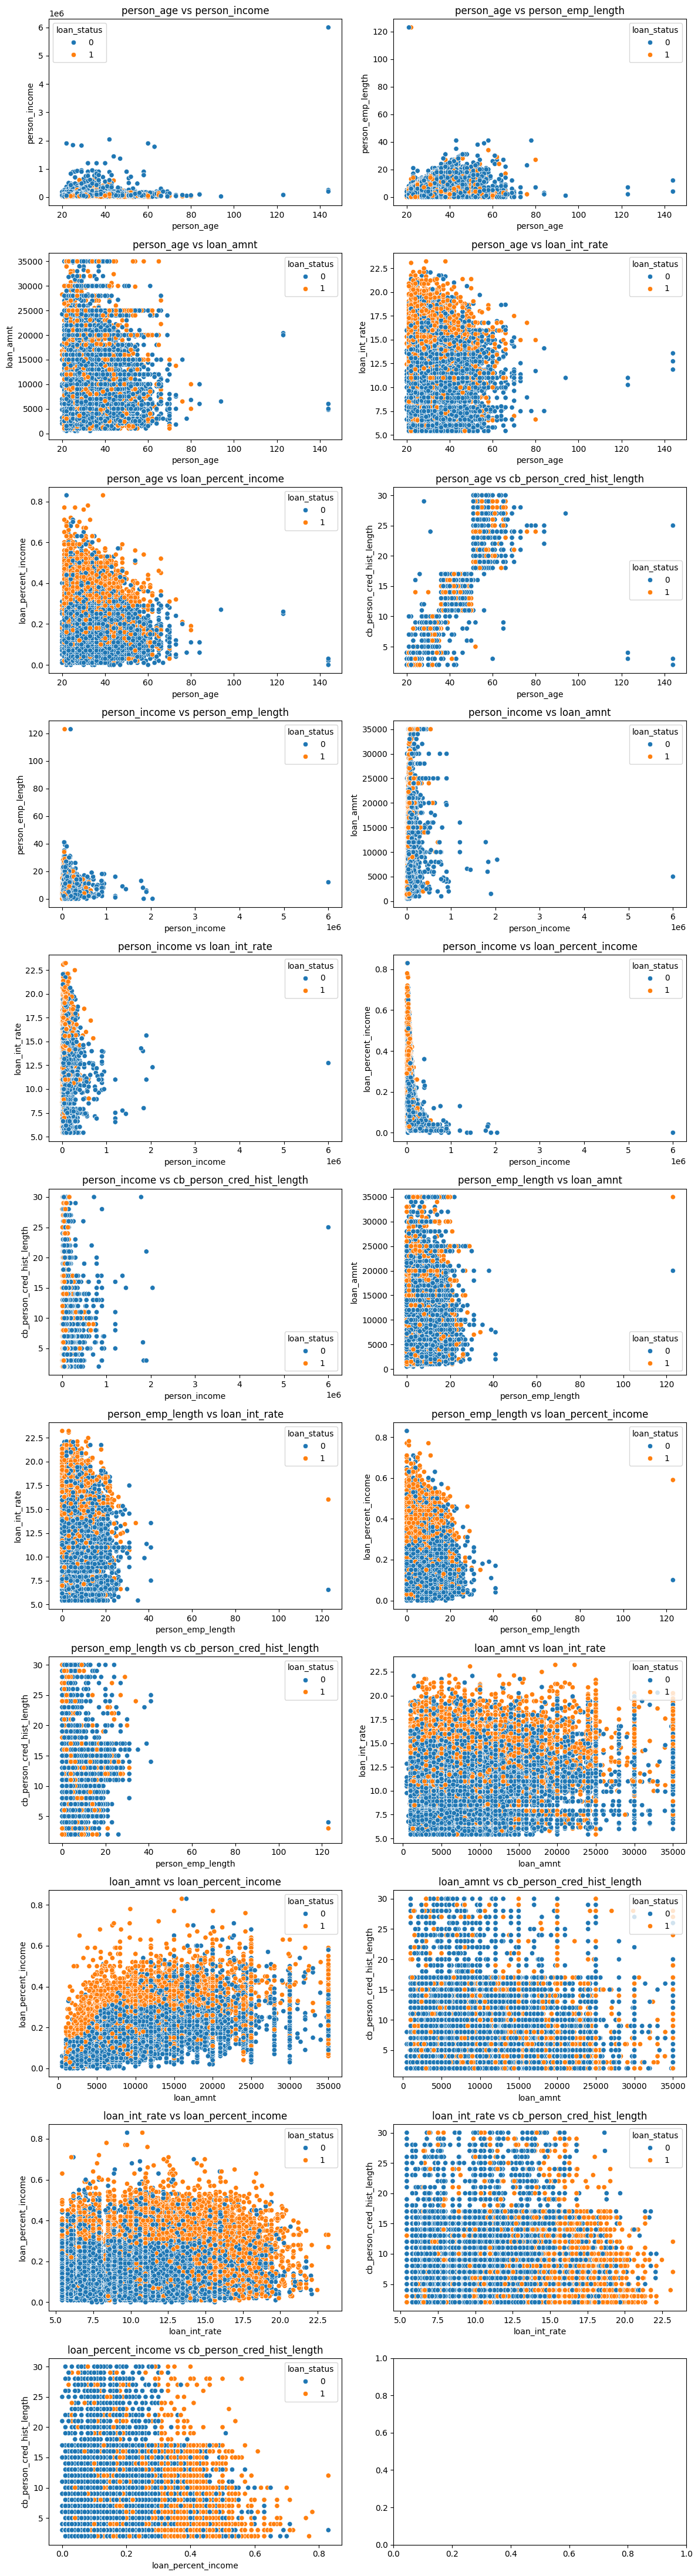

In [91]:
#@title 4.3 **Scatter plots**
import itertools

# Create a list of numerical columns excluding 'loan_status'
numerical_cols_for_scatter = [col for col in num_cols if col != 'loan_status']

# Create a list of all possible combinations of two numerical columns
combinations = list(itertools.combinations(numerical_cols_for_scatter, 2))

# Calculate the number of rows and columns for the grid based on the number of combinations
n_rows = (len(combinations) + 2 - 1) // 2
n_cols = 2


# Create the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

# Iterate through the combinations and plot scatter plots
for i, (col1, col2) in enumerate(combinations):
  ax = axes[i]
  sns.scatterplot(x = merged_df[col1], y = merged_df[col2], hue = merged_df['loan_status'], ax=ax)
  ax.set_title(f'{col1} vs {col2}')
  ax.set_xlabel(col1)
  ax.set_ylabel(col2)
  # ax.tick_params(axis='x', rotation=10, labelsize=7)


plt.tight_layout()
plt.show()


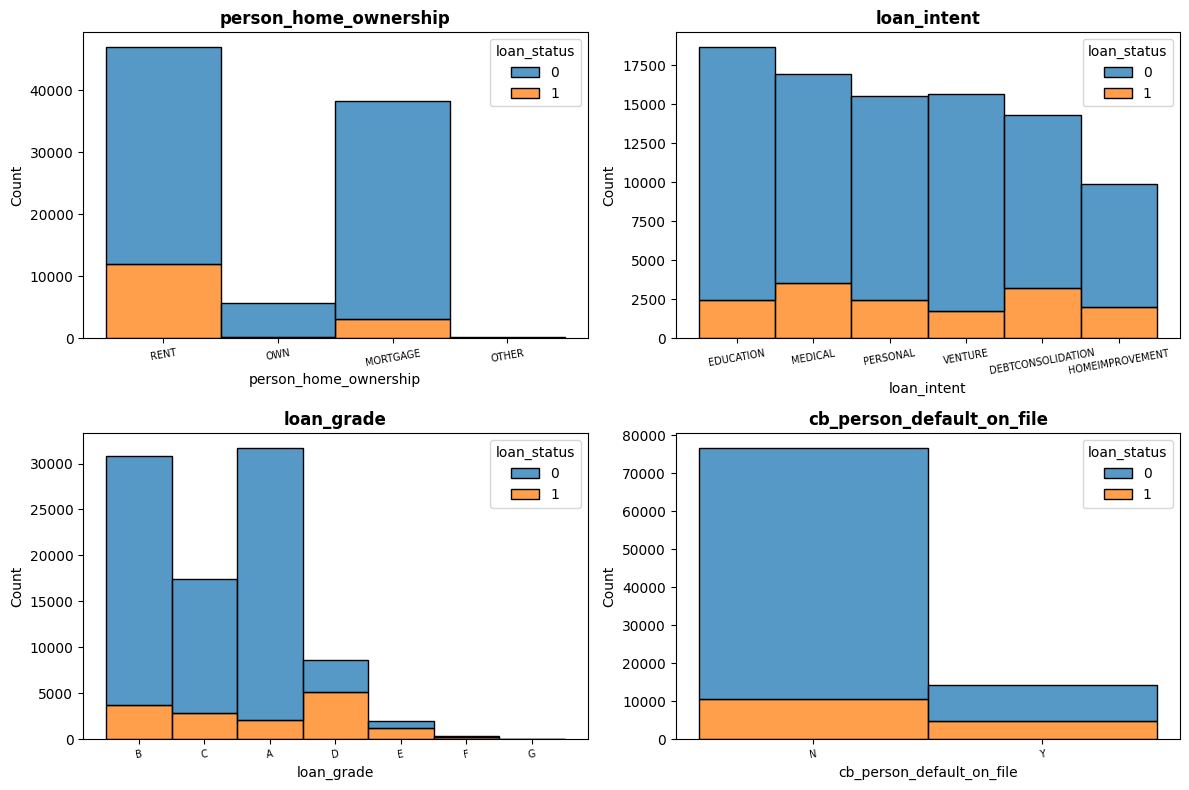

In [92]:
#@title 4.4 **Histogram of Obj columns based on Loan Status**

# Calculate the number of rows and columns for the grid
n_rows = 2
n_cols = 2

# Create the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))

# Iterate through the categorical columns and plot bar graphs
for i, col in enumerate(obj_cols):
    row = i // n_cols
    col_index = i % n_cols
    ax = axes[row, col_index]
    sns.histplot(data = merged_df, x=col, hue='loan_status', multiple="stack", ax=ax)
    ax.set_title(col, fontweight='bold')
    ax.tick_params(axis='x', rotation=10, labelsize=7)

plt.tight_layout()
plt.show()


## *5. Feature Encoding and Correlation*

In [ ]:
#@title 5.1 **Feature Encoding for Training set**
# train_df['person_home_ownership'].replace({'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3}, inplace=True)
# train_df['loan_intent'].replace({'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5}, inplace=True)
# train_df['loan_grade'].replace({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}, inplace=True)
# train_df['cb_person_default_on_file'].replace({'N': 0, 'Y': 1}, inplace=True)

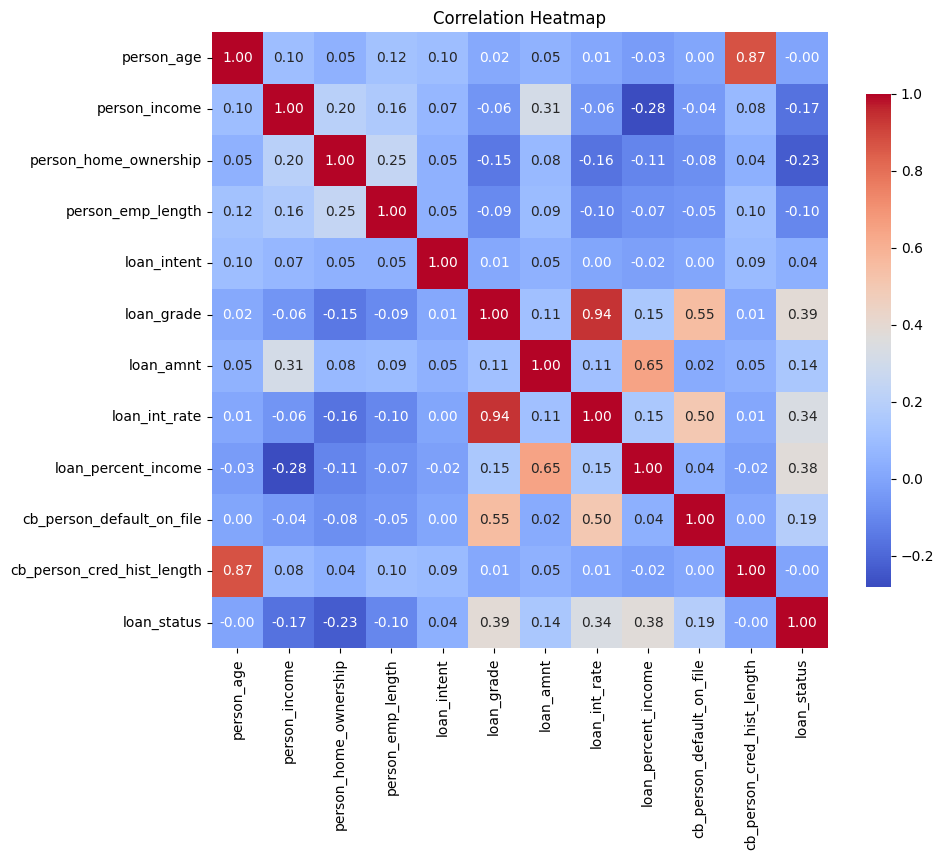

In [ ]:
#@title 5.2 **Correlation**
plt.figure(figsize=(10, 8))
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm', fmt='.2f',
            square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
#@title 5.3 **Feature Encoding for Testing set**
# test_df['person_home_ownership'].replace({'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3}, inplace=True)
# test_df['loan_intent'].replace({'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5}, inplace=True)
# test_df['loan_grade'].replace({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}, inplace=True)
# test_df['cb_person_default_on_file'].replace({'N': 0, 'Y': 1}, inplace=True)

## *6. Outlier Detection*

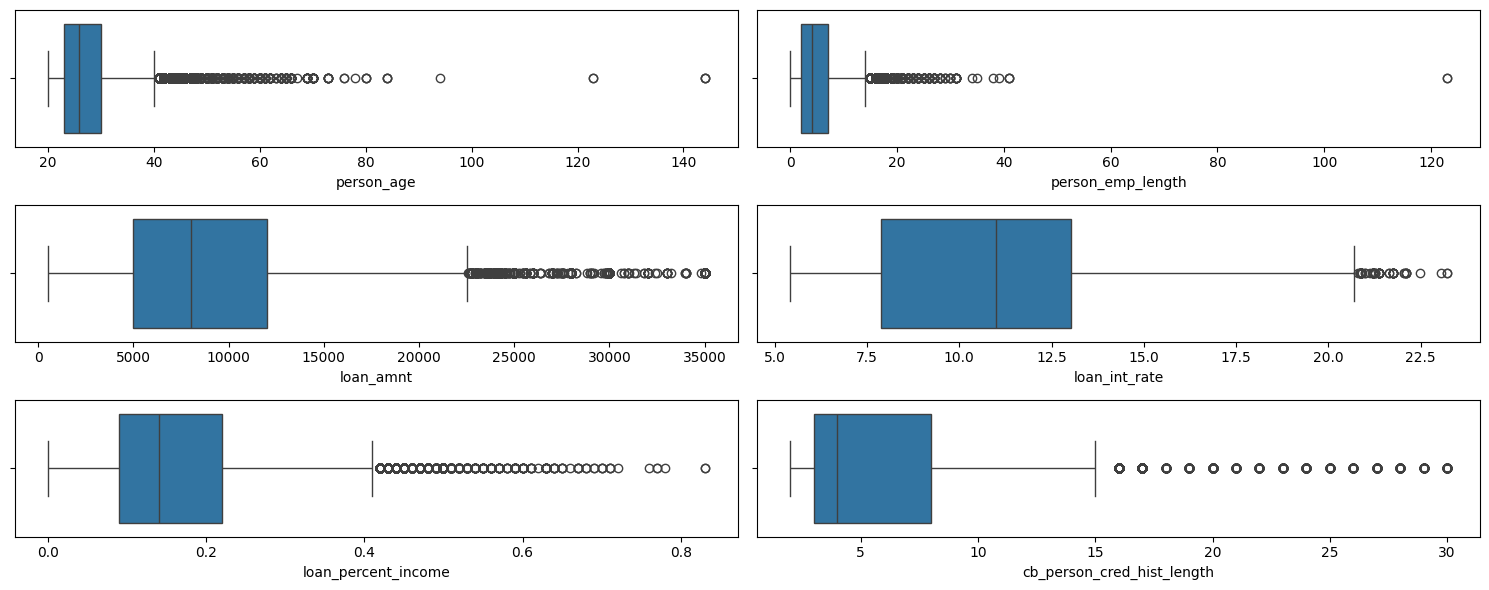

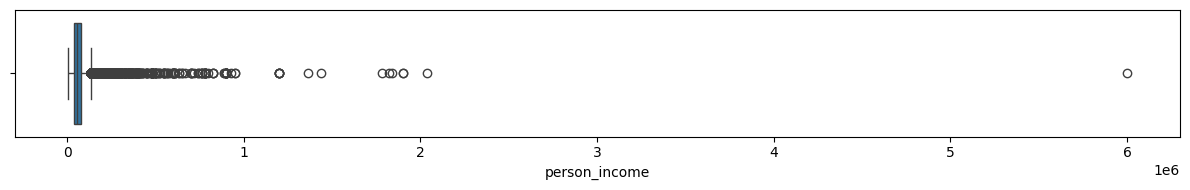

In [93]:
#@title 6.1 **Outlier detection using Box plot**

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 6))
axes = axes.flatten()

for i, col in enumerate(['person_age', 'person_emp_length', 'loan_amnt',
                         'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']):
    sns.boxplot(x = merged_df[col], ax=axes[i])
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 2))
sns.boxplot(x = merged_df['person_income'])
plt.tight_layout()
plt.show()


### 6.2 **Removing descrepancy for Age and Emp length**

In [95]:
merged_df = merged_df[(merged_df['person_age'] <= 100) & (merged_df['person_emp_length'] <= 100)]

print("\nShape of modified Train df:", merged_df.shape)
print(merged_df['loan_status'].value_counts())


Shape of modified Train df: (91050, 12)
loan_status
0    75613
1    15437
Name: count, dtype: int64


In [99]:
merged_df['loan_status'].value_counts()

loan_status
0    75613
1    15437
Name: count, dtype: int64

## *7. Model Training*

In [101]:
# Define X (features) and y (target)
X = merged_df.drop('loan_status', axis=1)
y = merged_df['loan_status']

In [ ]:
# Initialize the scaler and scale the numerical features
# scaler = StandardScaler()

# # Fit the scaler on training data and transform both training and testing sets
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

### CatBoost Model fitting and prediction

In [102]:
from google.colab import output
output.enable_custom_widget_manager()

In [117]:
#@title CatBoost Classifier

model = CatBoostClassifier(loss_function = 'Logloss', #binarycrossentropy
                          random_seed = 43,  # randomness set #auto_class_weights='Balanced', #for unbalanced data
                          eval_metric = 'AUC:hints=skip_train~false',  #ROC
                          cat_features = obj_cols,   #obj_cols  #grow_policy=#symmetric, depthwise, lossguide
                          early_stopping_rounds = 114,
                          max_bin = 212,
                          learning_rate = 0.16256079521573688,
                          depth = 11,
                          iterations = 1925,
                          bagging_temperature = 2.8804275858125608,
                          subsample = 0.7260629608362812,
                          colsample_bylevel = 0.9398220968072138,
                          min_data_in_leaf = 854.880082528555,
                          l2_leaf_reg = 2.0419303386733124e-06,
                          grow_policy = 'Depthwise',
                          leaf_estimation_iterations = 1,
                          scale_pos_weight = 4,
                          random_strength = 1.0133345946078725,
                          leaf_estimation_method = 'Newton'
                         )

{'early_stopping_rounds': 114, 'max_bin': 212, 'learning_rate': 0.16256079521573688, 'depth': 11, 'iterations': 1925, 'bagging_temperature': 2.8804275858125608, 'subsample': 0.7260629608362812, 'colsample_bylevel': 0.9398220968072138, 'min_data_in_leaf': 854.880082528555, 'l2_leaf_reg': 2.0419303386733124e-06, 'grow_policy': 'Depthwise', 'leaf_estimation_iterations': 1, 'scale_pos_weight': 2.695523242778921, 'random_strength': 1.0133345946078725, 'leaf_estimation_method': 'Newton'}

{'early_stopping_rounds': 114, 'max_bin': 212, 'learning_rate': 0.16256079521573688, 'depth': 11, 'iterations': 1925, 'bagging_temperature': 2.8804275858125608, 'subsample': 0.7260629608362812, 'colsample_bylevel': 0.9398220968072138, 'min_data_in_leaf': 854.880082528555, 'l2_leaf_reg': 2.0419303386733124e-06, 'grow_policy': 'Depthwise', 'leaf_estimation_iterations': 1, 'scale_pos_weight': 2.695523242778921, 'random_strength': 1.0133345946078725, 'leaf_estimation_method': 'Newton'}

In [105]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [118]:
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          plot=True,
          plot_file='catboost_plot.html')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8899747	test: 0.8882023	best: 0.8882023 (0)	total: 230ms	remaining: 7m 22s
1:	learn: 0.9084649	test: 0.9049124	best: 0.9049124 (1)	total: 451ms	remaining: 7m 13s
2:	learn: 0.9163158	test: 0.9133842	best: 0.9133842 (2)	total: 668ms	remaining: 7m 8s
3:	learn: 0.9202277	test: 0.9164184	best: 0.9164184 (3)	total: 903ms	remaining: 7m 13s
4:	learn: 0.9244430	test: 0.9203069	best: 0.9203069 (4)	total: 1.13s	remaining: 7m 15s
5:	learn: 0.9260218	test: 0.9216371	best: 0.9216371 (5)	total: 1.37s	remaining: 7m 18s
6:	learn: 0.9282548	test: 0.9231368	best: 0.9231368 (6)	total: 1.59s	remaining: 7m 16s
7:	learn: 0.9300436	test: 0.9251350	best: 0.9251350 (7)	total: 1.69s	remaining: 6m 45s
8:	learn: 0.9316269	test: 0.9268035	best: 0.9268035 (8)	total: 1.8s	remaining: 6m 24s
9:	learn: 0.9330128	test: 0.9286057	best: 0.9286057 (9)	total: 1.92s	remaining: 6m 8s
10:	learn: 0.9344901	test: 0.9296047	best: 0.9296047 (10)	total: 2.04s	remaining: 5m 54s
11:	learn: 0.9356091	test: 0.9311125	best: 0

In [119]:
from IPython.display import HTML
with open('catboost_plot.html', 'r') as f:
  html_content = f.read()
display(HTML(html_content))

In [120]:
print(model.get_best_iteration())

211


In [121]:
print(model.get_best_score())

{'learn': {'Logloss': 0.14387492504547222, 'AUC': 0.9904665903220863}, 'validation': {'Logloss': 0.24794180880872926, 'AUC': 0.9579702245495799}}


In [122]:
model.get_feature_importance(prettified=True,)

Feature Id  Importances
0                person_income    27.255950
1          loan_percent_income    16.882953
2                   loan_grade    12.462778
3        person_home_ownership    10.394882
4                loan_int_rate    10.022365
5                  loan_intent     7.997299
6                    loan_amnt     5.558419
7            person_emp_length     3.994134
8                   person_age     3.336220
9   cb_person_cred_hist_length     1.766532
10   cb_person_default_on_file     0.328468

In [114]:
print(model.get_scale_and_bias())

(1.0, 0.0)


In [123]:
#predict probabilities
y_pred_catboost = model.predict_proba(test_df)[:, 1]

#Submitting csv
submission_catboost_df = pd.DataFrame({'id': test_df.index, 'loan_status': y_pred_catboost}) #.set_index('id')
submission_catboost_df

id  loan_status
0      58645     0.999738
1      58646     0.104686
2      58647     0.815175
3      58648     0.023997
4      58649     0.073625
...      ...          ...
39093  97738     0.143291
39094  97739     0.016546
39095  97740     0.036462
39096  97741     0.555007
39097  97742     0.992844

[39098 rows x 2 columns]

In [124]:
submission_catboost_df.to_csv('submission_catboost_8.csv', index=False)
submission_catboost_df.shape

(39098, 2)

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()